In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import seaborn as sbrn
import numpy as np
import re
import datetime

%matplotlib inline

In [2]:
dat = pd.read_csv('../data/water_pump/training.csv', header=0)

In [3]:
labels = pd.read_csv('../data/water_pump/training_labels.csv', header=0)
#join labels to dat on "id" (left outer)

dat=dat.merge(labels, how='left', left_on='id', right_on='id',copy=False)

In [4]:
pd.set_option('display.max_columns', 50)
dat.sample(5)

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,basin,subvillage,region,region_code,district_code,lga,ward,population,public_meeting,recorded_by,scheme_management,scheme_name,permit,construction_year,extraction_type,extraction_type_group,extraction_type_class,management,management_group,payment,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,status_group
34055,32962,0.0,2011-07-22,World Vision,0,DWE,31.768268,-1.349268,Kibimbili,0,Lake Victoria,Buliampulu,Kagera,18,2,Bukoba Rural,Kabaragaine,0,True,GeoData Consultants Ltd,VWC,NaN,True,0,gravity,gravity,gravity,vwc,user-group,never pay,never pay,soft,good,enough,enough,spring,spring,groundwater,improved spring,improved spring,functional
47411,53843,250.0,2013-02-09,Imf,1282,Government,29.889779,-4.491243,Kwa Yusufu,0,Lake Tanganyika,Kifulifuli,Kigoma,16,2,Kasulu,Janda,300,True,GeoData Consultants Ltd,Water authority,Nyasovu,True,2007,gravity,gravity,gravity,water board,user-group,pay monthly,monthly,soft,good,enough,enough,river,river/lake,surface,communal standpipe,communal standpipe,functional
3192,64517,50.0,2011-03-23,Private Individual,14,Da,38.891389,-6.563976,Msikitini,0,Wami / Ruvu,Buma Magharibi,Pwani,6,1,Bagamoyo,Kiromo,200,True,GeoData Consultants Ltd,Company,Bagamoyo wate,True,2010,ksb,submersible,submersible,private operator,commercial,pay per bucket,per bucket,soft,good,enough,enough,river,river/lake,surface,communal standpipe,communal standpipe,functional
42192,16121,0.0,2013-02-18,Kalitasi,1470,Kalitasi,37.984706,-4.224608,Zahanati,0,Pangani,Mwala,Kilimanjaro,3,3,Same,Vuje,120,True,GeoData Consultants Ltd,VWC,Ntenga Water Supply,True,2002,gravity,gravity,gravity,vwc,user-group,never pay,never pay,soft,good,insufficient,insufficient,spring,spring,groundwater,communal standpipe,communal standpipe,functional
42950,14403,0.0,2012-10-31,Tlc,0,TLC,32.059683,-5.053477,Ezekiel Elias,0,Lake Tanganyika,Urambo Magharibi Kaskazini,Tabora,14,4,Urambo,Urambo,0,True,GeoData Consultants Ltd,Private operator,NaN,True,0,other,other,other,private operator,commercial,never pay,never pay,milky,milky,enough,enough,shallow well,shallow well,groundwater,other,other,non functional


In [5]:
dat.shape

(59400, 41)

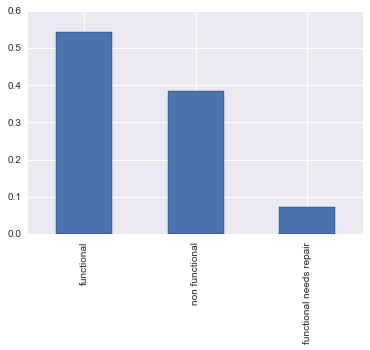

In [7]:
# OUTCOME VARIABLE CLASS PROPORTIONS

dat.status_group.value_counts(normalize=True).plot(kind='bar')
#class "functional needs repair" is severely imbalanced (<10% of dataset)

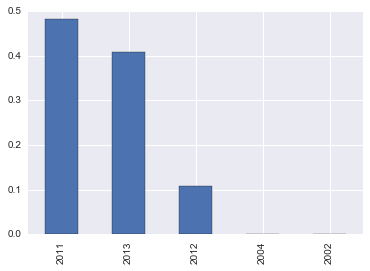

In [6]:
# TIME ANALYSIS
#not a time series, readings are sporadic, there are gaps in years
dat['date_recorded']=pd.to_datetime(dat.date_recorded)
dat['year']=dat.date_recorded.dt.year

#2004 and 2002 datapoints; <1% of the dataset combined
dat.year.value_counts(normalize=True).plot(kind='bar')

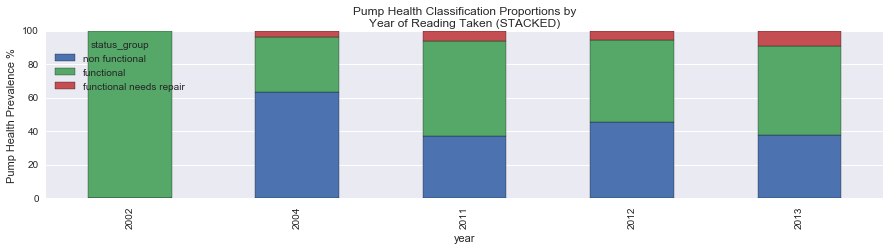

In [129]:
# Checking out outcome variable proportion by year reading taken:

temp=pd.crosstab(dat.status_group, dat.year).apply(lambda col: ((col/col.sum()).round(3))*100, axis=0)
temp=temp.reindex(['non functional','functional','functional needs repair'])
temp.transpose().plot(kind='bar',legend='status_group',stacked=True,figsize=(15,3), 
                      title='Pump Health Classification Proportions by\nYear of Reading Taken (STACKED)')
plt.ylabel( 'Pump Health Prevalence %')

#we see that 2002 is misleading in its classification distribution (Only 1 data point in 2002). Suggest removing that.

In [104]:
# Checking out Pump health proportion by construction years:
temp1=pd.crosstab(dat.status_group, dat.construction_year).apply(lambda col: ((col/col.sum()).round(3))*100, axis=0)
temp1=temp1.reindex(['non functional','functional','functional needs repair'])
temp1

construction_year,0,1960,1961,1962,1963,1964,1965,1966,1967,1968,1969,1970,1971,1972,1973,1974,1975,1976,1977,1978,1979,1980,1981,1982,1983,...,1989,1990,1991,1992,1993,1994,1995,1996,1997,1998,1999,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013
status_group,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
non functional,40.4,70.6,76.2,73.3,56.5,80.0,36.8,64.7,45.5,66.2,69.5,72.3,39.3,65.3,65.8,59.6,57.7,66.9,64.4,49.6,72.4,60.8,59.7,61.0,57.4,...,43.4,45.0,51.2,37.2,47.5,42.7,34.1,46.5,44.4,34.9,24.3,32.3,31.9,30.2,30.1,31.1,34.0,30.8,24.6,24.8,24.5,20.1,18.7,28.3,41.5
functional,51.0,23.5,9.5,23.3,36.5,17.5,57.9,35.3,35.2,28.6,25.4,24.1,56.6,25.1,29.9,34.6,33.0,20.5,30.7,41.1,21.4,31.8,35.7,31.7,38.3,...,52.2,48.8,43.5,56.4,46.9,51.5,58.5,47.6,45.2,56.1,70.9,61.2,61.3,64.4,64.4,62.7,57.2,60.0,68.1,70.4,70.0,76.5,75.1,67.0,58.0
functional needs repair,8.6,5.9,14.3,3.3,7.1,2.5,5.3,0.0,19.3,5.2,5.1,3.6,4.1,9.6,4.3,5.8,9.4,12.6,5.0,9.4,6.2,7.4,4.6,7.3,4.3,...,4.4,6.2,5.2,6.4,5.6,5.8,7.4,5.9,10.4,9.0,4.8,6.5,6.9,5.4,5.5,6.2,8.8,9.2,7.3,4.9,5.4,3.4,6.2,4.7,0.6


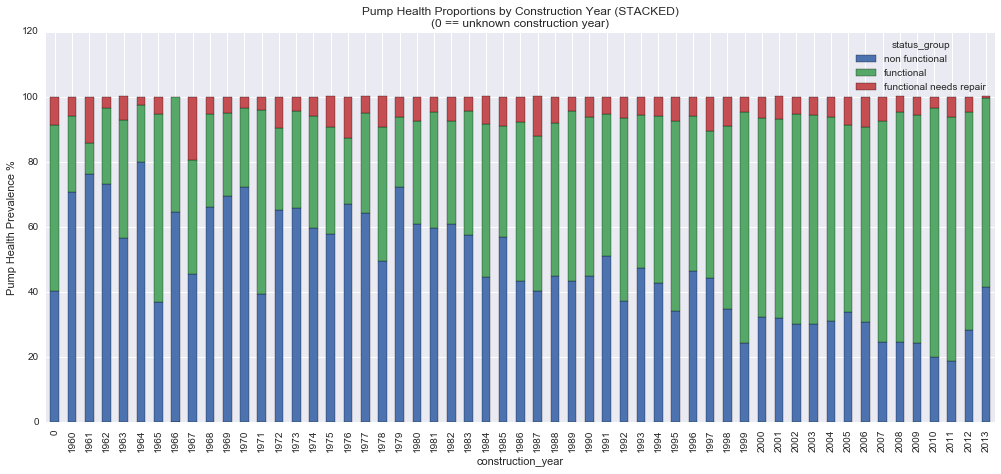

In [106]:
fig, ax = plt.subplots(1,1,figsize=(17,7))
temp1.transpose().plot(kind='bar', legend='status_group', stacked=True, ax=ax)
#temp1.iloc[1,:].plot(kind='bar', color='green', ax=ax, legend='status_group', bottom=temp1.iloc[0,:])
#temp1.iloc[2,:].plot(kind='bar', color='red', ax=ax, legend='status_group')
ax.set_ylabel('Pump Health Prevalence %')
ax.set_title('Pump Health Proportions by Construction Year (STACKED)\n(0 == unknown construction year)')

#not surprisingly, older pumps breakdown a lot more than the newer ones. 
#There's also the '0' group that's missing construction year. 
#pumps needing repair are more or less evenly spread out by age of pump
#all this suggests either that newer pumps breakdown less, or that maintenance is better lately, or both

In [115]:
#what % of "construction years" are missing?
round((len(dat[dat.construction_year==0])/float(len(dat)))*100, 2)

34.86

In [9]:
# NUMERIC VARIABLES ANALYSIS

dat.describe(include=['int64','float64','float32']) 
#coded categoricals also show up

,id,amount_tsh,gps_height,longitude,latitude,num_private,region_code,district_code,population,construction_year,year
count,59400.000000,59400.000000,59400.000000,59400.000000,5.940000e+04,59400.000000,59400.000000,59400.000000,59400.000000,59400.000000,59400.000000
mean,37115.131768,317.650385,668.297239,34.077427,-5.706033e+00,0.474141,15.297003,5.629747,179.909983,1300.652475,2011.921667
std,21453.128371,2997.574558,693.116350,6.567432,2.946019e+00,12.236230,17.587406,9.633649,471.482176,951.620547,0.958758
min,0.000000,0.000000,-90.000000,0.000000,-1.164944e+01,0.000000,1.000000,0.000000,0.000000,0.000000,2002.000000
25%,18519.750000,0.000000,0.000000,33.090347,-8.540621e+00,0.000000,5.000000,2.000000,0.000000,0.000000,2011.000000
50%,37061.500000,0.000000,369.000000,34.908743,-5.021597e+00,0.000000,12.000000,3.000000,25.000000,1986.000000,2012.000000
75%,55656.500000,20.000000,1319.250000,37.178387,-3.326156e+00,0.000000,17.000000,5.000000,215.000000,2004.000000,2013.000000
max,74247.000000,350000.000000,2770.000000,40.345193,-2.000000e-08,1776.000000,99.000000,80.000000,30500.000000,2013.000000,2013.000000


status_group
functional                 Axes(0.547727,0.125;0.352273x0.227941)
functional needs repair    Axes(0.547727,0.125;0.352273x0.227941)
non functional             Axes(0.547727,0.125;0.352273x0.227941)
Name: population, dtype: object

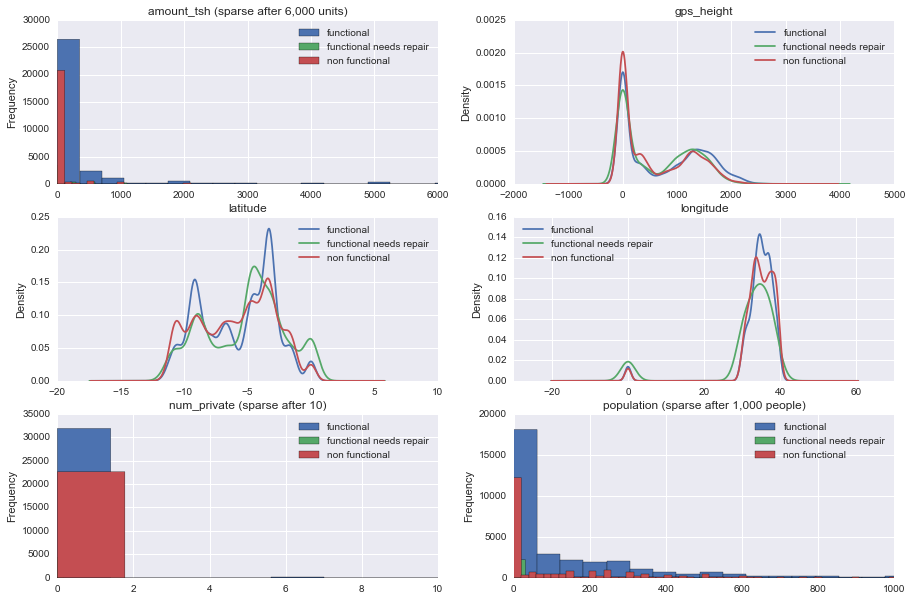

In [150]:
# TAKING A LOOK AT DISTRIBUTIONS OF CONTINUOUS VARIABLES, SEGMENTED BY STATUS_GROUP (pump health)

fig, ((ax1,ax2),(ax3,ax4),(ax5,ax6)) = plt.subplots(3,2,figsize=(15,10))
dat.groupby(dat.status_group)['amount_tsh'].plot.hist(ax=ax1,legend=True, title='amount_tsh (sparse after 6,000 units)', bins=1000, xlim=(0,6000)) #total static head (amount water available to waterpoint)
dat.groupby(dat.status_group)['gps_height'].plot(kind='kde',ax=ax2,legend=True,title='gps_height') #Altitude of the well
dat.groupby(dat.status_group)['latitude'].plot(kind='kde',ax=ax3,legend=True, title='latitude')
dat.groupby(dat.status_group)['longitude'].plot(kind='kde',ax=ax4,legend=True, title='longitude')
dat.groupby(dat.status_group)['num_private'].plot.hist(ax=ax5,legend=True, title='num_private (sparse after 10)', bins=1000, xlim=(0,10)) #no desc
dat.groupby(dat.status_group)['population'].plot.hist(ax=ax6,legend=True, title='population (sparse after 1,000 people)',bins=500, xlim=(0,1000)) #pop around the well

In [ ]:
#gps height: more readings at lower altitudes; more repairs seem to be needed at higher heights
#latitude: higher lats (North) see less readings, more non functionals and repairs; mid-lats have healthiest data
#longitude: more or less normally distributed readings going from east to west; 

# need separate and deeper look at location parameters

In [182]:
#% of missing num_private values
round(len(dat[dat.num_private==0])/float(len(dat)),3)*100

98.7

In [186]:
#% of missing population values
round(len(dat[dat.population==0])/float(len(dat)),3)*100

36.0

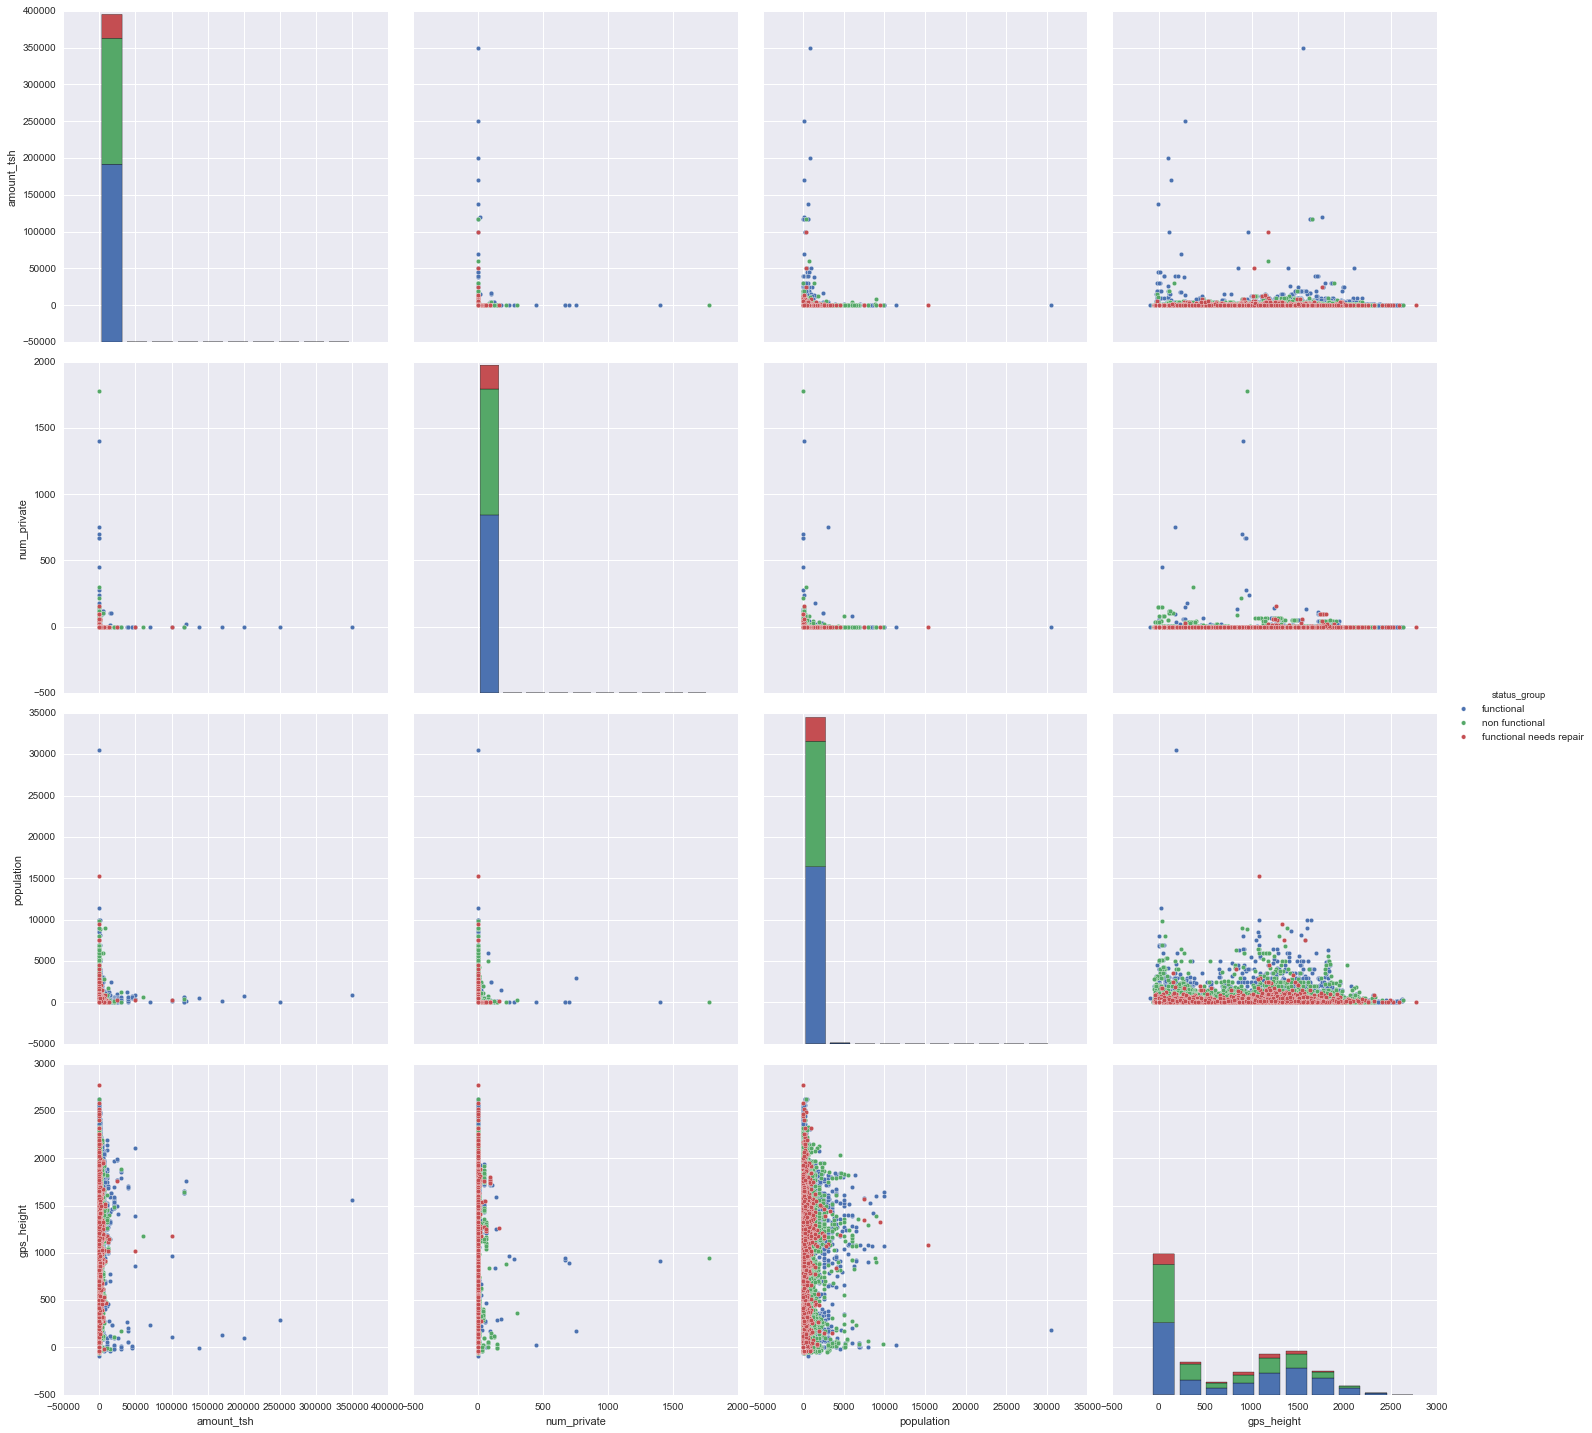

In [195]:
#closer look at data
sbrn.pairplot(dat.loc[:,['amount_tsh','num_private','population','gps_height','status_group']], 
              hue="status_group",
              size=5)


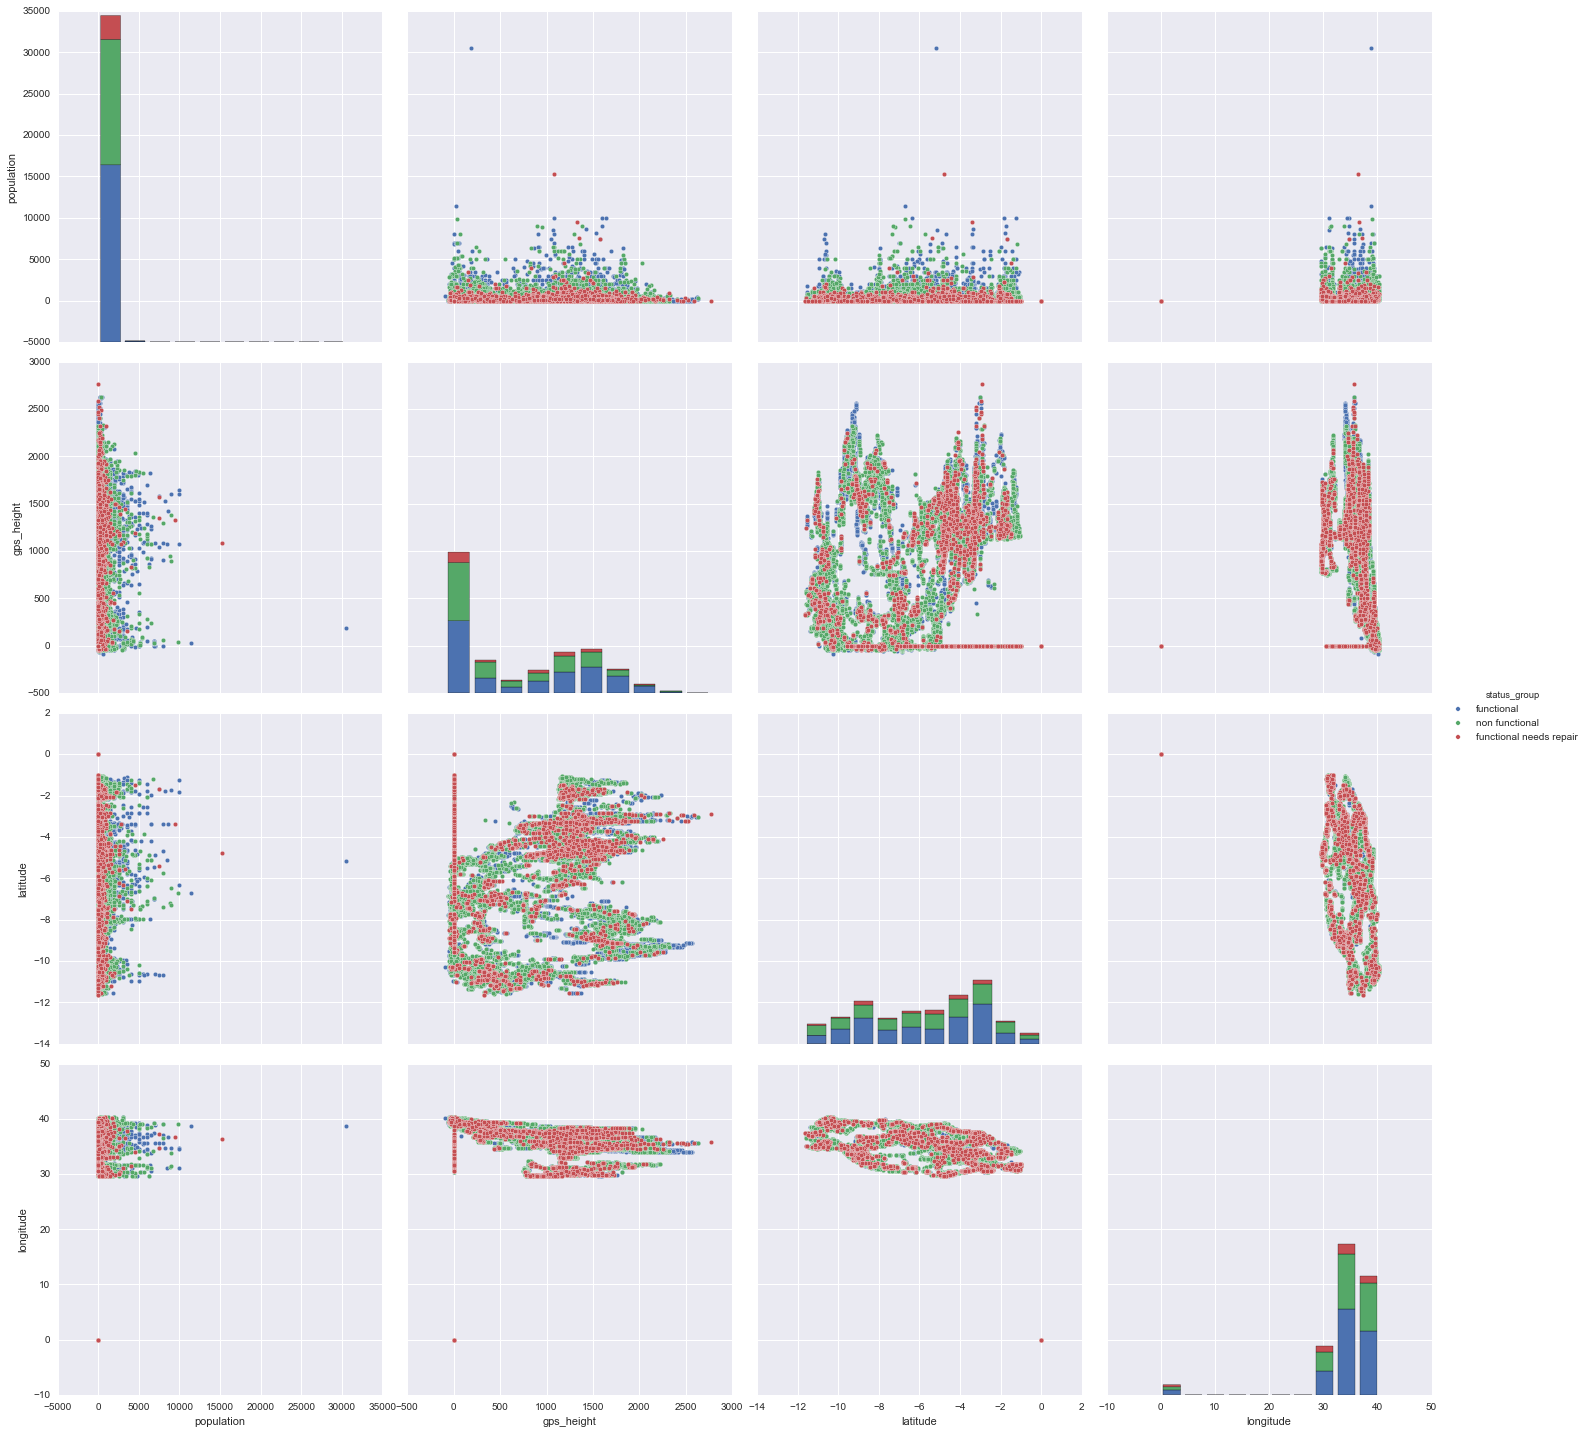

In [194]:
#too many missing values in num_private and amount_tsh, hard to infer anything. Remove and insert lat, long for some location analysis
sbrn.pairplot(dat.loc[:,['population','gps_height','status_group','latitude','longitude']], 
              hue="status_group",
              size=5)

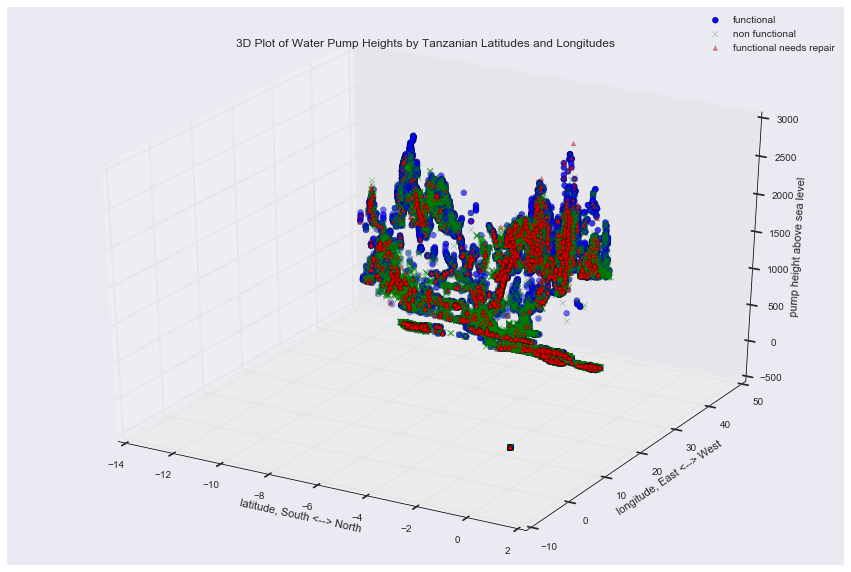

In [251]:
#okay, population densities and water pumps increase around North-Mid to North-West areas; still hard to see relationships.
#let's go 3D with lat, long, and gps-height; by pump health

from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(xs=dat.loc[dat.status_group.isin(['functional']),'latitude'],
           ys=dat.loc[dat.status_group.isin(['functional']),'longitude'],
           zs=dat.loc[dat.status_group.isin(['functional']),'gps_height'],
           c='blue',
           marker='.',
           s=144,
          label='functional')
ax.scatter(xs=dat.loc[dat.status_group.isin(['non functional']),'latitude'],
           ys=dat.loc[dat.status_group.isin(['non functional']),'longitude'],
           zs=dat.loc[dat.status_group.isin(['non functional']),'gps_height'],
           c='green',
           marker='x',
           alpha=0.75,
          s=34,
          label='non functional')
ax.scatter(xs=dat.loc[dat.status_group.isin(['functional needs repair']),'latitude'],
           ys=dat.loc[dat.status_group.isin(['functional needs repair']),'longitude'],
           zs=dat.loc[dat.status_group.isin(['functional needs repair']),'gps_height'],
           c='red',
           marker='^',
           alpha=0.5,
          s=21,
          label='functional needs repair')
ax.set_xlabel('latitude, South <--> North')
ax.set_ylabel('longitude, East <--> West')
ax.set_zlabel('pump height above sea level')
#ax.xy_dataLim([-14,30],[0,50])
#ax.ylim(10,50)
#ax.zlim(-500,2500)
ax.legend()
ax.set_title('3D Plot of Water Pump Heights by Tanzanian Latitudes and Longitudes')

# Inserting some additional analysis (some may be redundant)

In [3]:
import pandas as pd

training_labels_df = pd.read_csv('../data/water_pump/training_labels.csv', header=0)
training_values_df = pd.read_csv('../data/water_pump/training.csv', header=0)

#training_labels_df = pd.read_csv(training_labels_file)
#training_values_df = pd.read_csv(training_values_file)

training_values_df['status_group'] = training_labels_df['status_group']

# Look at pump status with respect to geographical location

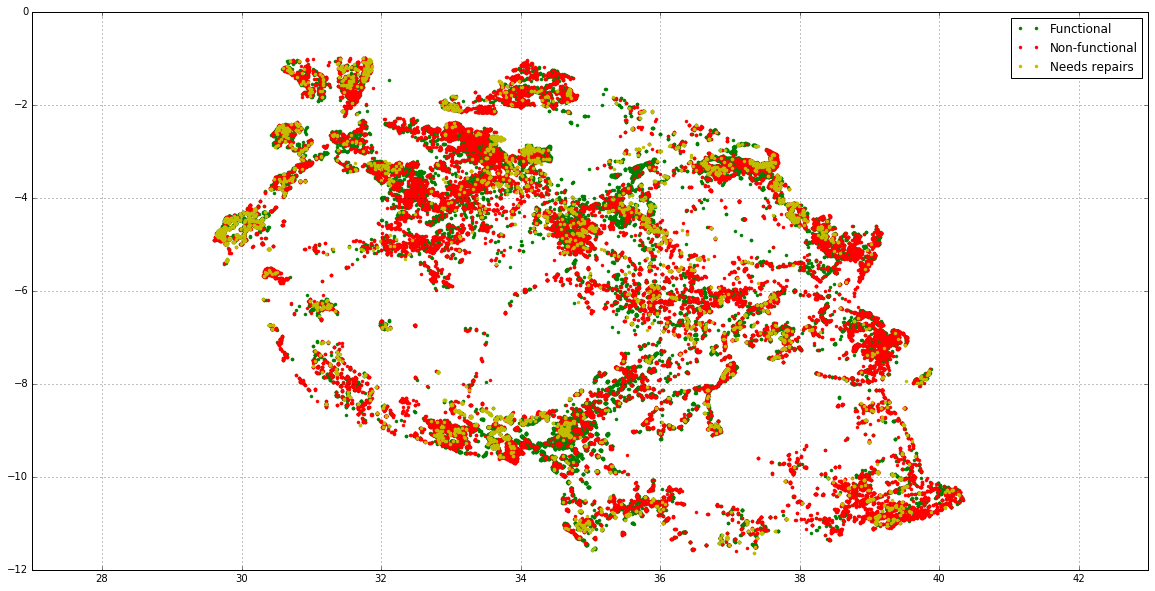

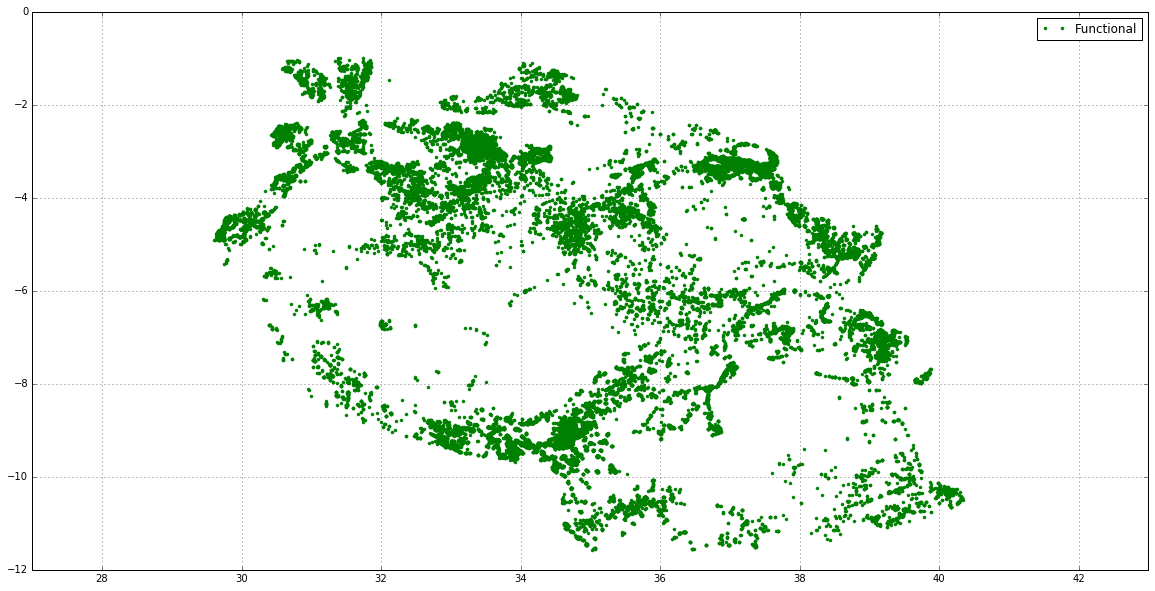

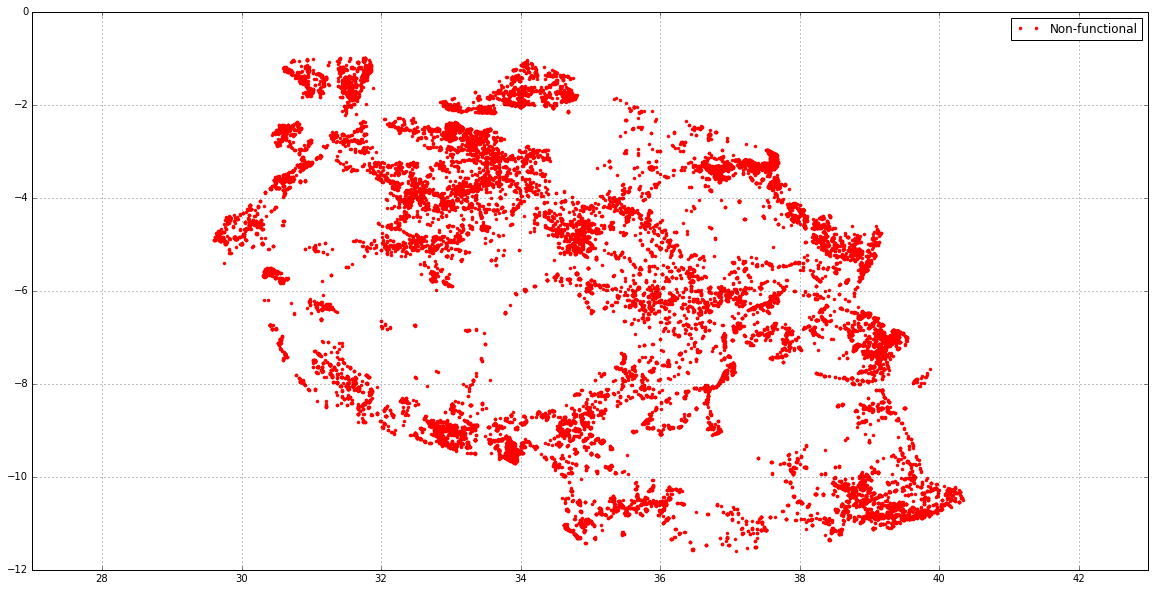

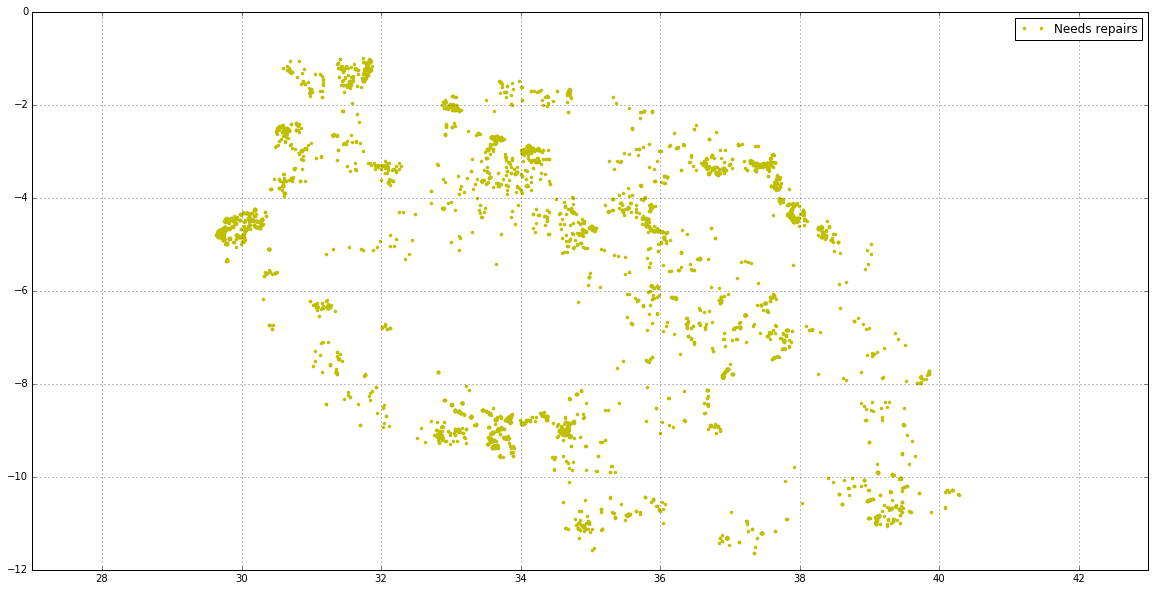

In [6]:
# separate data by status of pump
func_df = training_values_df[training_values_df['status_group']=='functional']
nonfunc_df = training_values_df[training_values_df['status_group']=='non functional']
repair_df = training_values_df[training_values_df['status_group']=='functional needs repair']

# plot pump status on coordinate grid
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(20,10))
plt.plot(func_df.longitude,func_df.latitude,'g.')
plt.plot(nonfunc_df.longitude,nonfunc_df.latitude,'r.')
plt.plot(repair_df.longitude,repair_df.latitude,'y.')
plt.legend(['Functional','Non-functional','Needs repairs'])
plt.axis([27,43,-12,0])
plt.grid(True)

plt.figure(figsize=(20,10))
plt.plot(func_df.longitude,func_df.latitude,'g.')
plt.legend(['Functional'])
plt.axis([27,43,-12,0])
plt.grid(True)

plt.figure(figsize=(20,10))
plt.plot(nonfunc_df.longitude,nonfunc_df.latitude,'r.')
plt.legend(['Non-functional'])
plt.axis([27,43,-12,0])
plt.grid(True)

plt.figure(figsize=(20,10))
plt.plot(repair_df.longitude,repair_df.latitude,'y.')
plt.legend(['Needs repairs'])
plt.axis([27,43,-12,0])
plt.grid(True)

# Show status_group rates for various categorical features
Categorical features that look like good candidates from this (some of these may be redundant):
**basin, region, region_code, district_code, lga, public_meeting, scheme_management, permit, construction_year, extraction_type, extraction_type_group, management, management_group, payment, payment_type, water_quality,  quality_group, quantity_group, source, source_type, waterpoint_type, waterpoint_type_group 

Others that may be possible:
**funder, ward, scheme_name, source_class, 

In [7]:
def calc_percentage(x):
    vals = x.status_group.values
    total = len(vals)
    perc_func = (vals == 'functional').sum() / float(total)
    perc_nonfunc = (vals == 'non functional').sum() / float(total)
    perc_repair = (vals == 'functional needs repair').sum() / float(total)
    
    return pd.DataFrame([[total, perc_func,perc_nonfunc,perc_repair]],
                        columns=['total','functional','non functional','functional needs repair'])

In [8]:
from IPython.display import display

df_dict = {}

indices = ['funder','installer','wpt_name','basin', 'subvillage', 'region', 'region_code', 'district_code',
           'lga', 'ward', 'public_meeting', 'recorded_by','scheme_management', 'scheme_name', 'permit', 
           'construction_year','extraction_type', 'extraction_type_group', 'extraction_type_class','management', 
           'management_group', u'payment', u'payment_type','water_quality', 'quality_group', 'quantity','quantity_group',
           'source', u'source_type', u'source_class', u'waterpoint_type','waterpoint_type_group']
for idx in indices:
    df = training_values_df.groupby([idx]).apply(calc_percentage).sort_values('functional')
    display(df)
    df_dict[idx] = df

,,total,functional,non functional,functional needs repair
funder,,,,,
Rc Missi,0,1,0.0,1.000000,0.000000
Grail Mission Kiseki Bar,0,1,0.0,0.000000,1.000000
Greec,0,5,0.0,1.000000,0.000000
Greinaker,0,3,0.0,1.000000,0.000000
Treedap,0,1,0.0,1.000000,0.000000
Seif Ndago,0,1,0.0,1.000000,0.000000
H4ccp,0,1,0.0,1.000000,0.000000
Tumaini Fund,0,5,0.0,0.800000,0.200000
Mp,0,2,0.0,1.000000,0.000000


,,total,functional,non functional,functional needs repair
installer,,,,,
Magani,0,1,0.0,1.000000,0.000000
Rural Drinking Water Supply,0,3,0.0,1.000000,0.000000
Hanja,0,1,0.0,1.000000,0.000000
Hasawa,0,1,0.0,1.000000,0.000000
Rps,0,1,0.0,1.000000,0.000000
Hemed Abdalkah,0,1,0.0,1.000000,0.000000
Hemed Abdallah,0,1,0.0,1.000000,0.000000
Rotar,0,2,0.0,0.500000,0.500000
Hery,0,1,0.0,1.000000,0.000000


,,total,functional,non functional,functional needs repair
wpt_name,,,,,
24,0,1,0.0,1.0,0.0
Kwa John Kigufo,0,1,0.0,1.0,0.0
Kwabugoyi,0,1,0.0,0.0,1.0
Kwa John Kimotare,0,1,0.0,1.0,0.0
Kwabugale,0,1,0.0,1.0,0.0
Kwa John Kiyage,0,1,0.0,1.0,0.0
Kwa John Komba,0,1,0.0,1.0,0.0
Kwa John Kuba,0,1,0.0,0.0,1.0
Kwabruno,0,1,0.0,1.0,0.0


,,total,functional,non functional,functional needs repair
basin,,,,,
Ruvuma / Southern Coast,0,4493,0.371689,0.555753,0.072557
Lake Rukwa,0,2454,0.407498,0.482478,0.110024
Lake Tanganyika,0,6432,0.483053,0.401586,0.115361
Lake Victoria,0,10248,0.497658,0.405835,0.096507
Wami / Ruvu,0,5987,0.523802,0.431268,0.044931
Internal,0,7785,0.575723,0.352730,0.071548
Pangani,0,8940,0.600895,0.345749,0.053356
Rufiji,0,7976,0.635406,0.309804,0.054789
Lake Nyasa,0,5085,0.653687,0.297148,0.049164


,,total,functional,non functional,functional needs repair
subvillage,,,,,
Mapang,0,1,0.0,1.000000,0.000000
Masasi Kati,0,1,0.0,1.000000,0.000000
Masasi Ya Leo,0,2,0.0,0.500000,0.500000
Masaula,0,2,0.0,1.000000,0.000000
Masengese,0,2,0.0,0.000000,1.000000
Masengete,0,1,0.0,1.000000,0.000000
Masenku,0,1,0.0,1.000000,0.000000
Maseseweni,0,2,0.0,1.000000,0.000000
Maseseweni Chini,0,1,0.0,1.000000,0.000000


,,total,functional,non functional,functional needs repair
region,,,,,
Lindi,0,1546,0.297542,0.642303,0.060155
Mtwara,0,1730,0.302890,0.624277,0.072832
Rukwa,0,1808,0.391040,0.534292,0.074668
Tabora,0,1959,0.432874,0.544155,0.022971
Mara,0,1969,0.449975,0.519553,0.030472
Dodoma,0,2201,0.458428,0.446615,0.094957
Singida,0,2093,0.483039,0.455805,0.061156
Kigoma,0,2816,0.484020,0.301847,0.214134
Mwanza,0,3102,0.484204,0.456802,0.058994


,,total,functional,non functional,functional needs repair
region_code,,,,,
40,0,1,0.000000,1.000000,0.000000
8,0,300,0.086667,0.863333,0.050000
90,0,917,0.211559,0.681570,0.106870
80,0,1238,0.348950,0.588045,0.063005
9,0,390,0.356410,0.589744,0.053846
15,0,1808,0.391040,0.534292,0.074668
14,0,1979,0.435574,0.540677,0.023749
20,0,1969,0.449975,0.519553,0.030472
99,0,423,0.451537,0.531915,0.016548


,,total,functional,non functional,functional needs repair
district_code,,,,,
0,0,23,0.173913,0.739130,0.086957
33,0,874,0.221968,0.665904,0.112128
80,0,12,0.250000,0.666667,0.083333
13,0,391,0.304348,0.621483,0.074169
63,0,195,0.317949,0.656410,0.025641
53,0,745,0.335570,0.629530,0.034899
43,0,505,0.421782,0.562376,0.015842
3,0,9998,0.495499,0.434587,0.069914
6,0,4074,0.504418,0.438635,0.056946


,,total,functional,non functional,functional needs repair
lga,,,,,
Nyamagana,0,1,0.000000,1.000000,0.000000
Nachingwea,0,300,0.086667,0.863333,0.050000
Ruangwa,0,291,0.178694,0.752577,0.068729
Masasi,0,528,0.195076,0.676136,0.128788
Kigoma Urban,0,71,0.211268,0.676056,0.112676
Newala,0,231,0.212121,0.658009,0.129870
Pangani,0,305,0.213115,0.777049,0.009836
Kiteto,0,193,0.233161,0.621762,0.145078
Chunya,0,298,0.241611,0.422819,0.335570


,,total,functional,non functional,functional needs repair
ward,,,,,
Aghondi,0,12,0.0,1.000000,0.000000
Kwadelo,0,16,0.0,0.875000,0.125000
Laghanga,0,2,0.0,1.000000,0.000000
Lake Jipe,0,13,0.0,1.000000,0.000000
Lemasule,0,8,0.0,1.000000,0.000000
Linda,0,1,0.0,0.000000,1.000000
Lionja,0,21,0.0,0.952381,0.047619
Liwale B,0,11,0.0,1.000000,0.000000
Lukokoda,0,10,0.0,1.000000,0.000000


,,total,functional,non functional,functional needs repair
public_meeting,,,,,
False,0,5055,0.429871,0.482690,0.087438
True,0,51011,0.556899,0.370195,0.072906


,,total,functional,non functional,functional needs repair
recorded_by,,,,,
GeoData Consultants Ltd,0,59400,0.543081,0.384242,0.072677


,,total,functional,non functional,functional needs repair
scheme_management,,,,,
SWC,0,97,0.206186,0.783505,0.010309
Company,0,1061,0.503299,0.461828,0.034873
Water authority,0,3153,0.513162,0.344751,0.142087
VWC,0,36793,0.515315,0.421249,0.063436
Parastatal,0,1680,0.575000,0.304762,0.120238
WUG,0,5206,0.577411,0.293507,0.129082
Other,0,766,0.597911,0.373368,0.028721
Trust,0,72,0.638889,0.291667,0.069444
Private operator,0,1063,0.685795,0.292568,0.021637


,,total,functional,non functional,functional needs repair
scheme_name,,,,,
Matale water project,0,2,0.0,1.00,0.00
Irin,0,3,0.0,1.00,0.00
Mradi wa maji matendo,0,16,0.0,1.00,0.00
Irrigation Scheme,0,3,0.0,1.00,0.00
Mradi wa maji Vijijni,0,6,0.0,1.00,0.00
Lenj,0,3,0.0,1.00,0.00
Iseke,0,4,0.0,0.75,0.25
Iseke water supply,0,5,0.0,1.00,0.00
Isikizya water supply,0,4,0.0,1.00,0.00


,,total,functional,non functional,functional needs repair
permit,,,,,
False,0,17492,0.517094,0.407443,0.075463
True,0,38852,0.554437,0.376145,0.069417


,,total,functional,non functional,functional needs repair
construction_year,,,,,
1961,0,21,0.095238,0.761905,0.142857
1964,0,40,0.175000,0.800000,0.025000
1976,0,414,0.205314,0.669082,0.125604
1979,0,192,0.213542,0.723958,0.062500
1962,0,30,0.233333,0.733333,0.033333
1960,0,102,0.235294,0.705882,0.058824
1970,0,411,0.240876,0.722628,0.036496
1972,0,708,0.251412,0.652542,0.096045
1969,0,59,0.254237,0.694915,0.050847


,,total,functional,non functional,functional needs repair
extraction_type,,,,,
other - mkulima/shinyanga,0,2,0.000000,1.000000,0.000000
other,0,6430,0.160031,0.807932,0.032037
climax,0,32,0.250000,0.750000,0.000000
other - play pump,0,85,0.341176,0.647059,0.011765
mono,0,2865,0.377661,0.577312,0.045026
windmill,0,117,0.427350,0.512821,0.059829
india mark iii,0,98,0.448980,0.540816,0.010204
walimi,0,48,0.479167,0.270833,0.250000
ksb,0,1415,0.496820,0.484806,0.018375


,,total,functional,non functional,functional needs repair
extraction_type_group,,,,,
other,0,6430,0.160031,0.807932,0.032037
mono,0,2865,0.377661,0.577312,0.045026
wind-powered,0,117,0.427350,0.512821,0.059829
other motorpump,0,122,0.434426,0.491803,0.073770
india mark iii,0,98,0.448980,0.540816,0.010204
other handpump,0,364,0.472527,0.472527,0.054945
submersible,0,6179,0.538760,0.420295,0.040945
swn 80,0,3670,0.569482,0.372752,0.057766
gravity,0,26780,0.599253,0.299888,0.100859


,,total,functional,non functional,functional needs repair
extraction_type_class,,,,,
other,0,6430,0.160031,0.807932,0.032037
motorpump,0,2987,0.379980,0.573820,0.046200
wind-powered,0,117,0.427350,0.512821,0.059829
submersible,0,6179,0.538760,0.420295,0.040945
gravity,0,26780,0.599253,0.299888,0.100859
handpump,0,16456,0.630469,0.309067,0.060464
rope pump,0,451,0.649667,0.312639,0.037694


,,total,functional,non functional,functional needs repair
management,,,,,
other - school,0,99,0.232323,0.757576,0.010101
company,0,685,0.389781,0.588321,0.021898
unknown,0,561,0.399287,0.552585,0.048128
water authority,0,904,0.493363,0.449115,0.057522
vwc,0,40507,0.504234,0.426864,0.068902
parastatal,0,1768,0.576923,0.303733,0.119344
trust,0,78,0.589744,0.333333,0.076923
other,0,844,0.598341,0.336493,0.065166
wug,0,6515,0.599540,0.301458,0.099002


,,total,functional,non functional,functional needs repair
management_group,,,,,
unknown,0,561,0.399287,0.552585,0.048128
user-group,0,52490,0.538236,0.387350,0.074414
other,0,943,0.559915,0.380700,0.059385
parastatal,0,1768,0.576923,0.303733,0.119344
commercial,0,3638,0.614349,0.353491,0.032161


,,total,functional,non functional,functional needs repair
payment,,,,,
unknown,0,8157,0.432512,0.514527,0.052961
never pay,0,25348,0.448911,0.475856,0.075233
other,0,1054,0.579696,0.308349,0.111954
pay when scheme fails,0,3914,0.620593,0.308636,0.070772
pay monthly,0,8300,0.660482,0.227831,0.111687
pay per bucket,0,8985,0.677796,0.276683,0.045520
pay annually,0,3642,0.752334,0.179846,0.067820


,,total,functional,non functional,functional needs repair
payment_type,,,,,
unknown,0,8157,0.432512,0.514527,0.052961
never pay,0,25348,0.448911,0.475856,0.075233
other,0,1054,0.579696,0.308349,0.111954
on failure,0,3914,0.620593,0.308636,0.070772
monthly,0,8300,0.660482,0.227831,0.111687
per bucket,0,8985,0.677796,0.276683,0.045520
annually,0,3642,0.752334,0.179846,0.067820


,,total,functional,non functional,functional needs repair
water_quality,,,,,
unknown,0,1876,0.140725,0.840618,0.018657
fluoride abandoned,0,17,0.352941,0.647059,0.000000
salty,0,4856,0.457166,0.496499,0.046334
coloured,0,490,0.502041,0.387755,0.110204
salty abandoned,0,339,0.513274,0.274336,0.212389
milky,0,804,0.544776,0.437811,0.017413
soft,0,50818,0.565941,0.357236,0.076823
fluoride,0,200,0.755000,0.180000,0.065000


,,total,functional,non functional,functional needs repair
quality_group,,,,,
unknown,0,1876,0.140725,0.840618,0.018657
salty,0,5195,0.460828,0.482002,0.057170
colored,0,490,0.502041,0.387755,0.110204
milky,0,804,0.544776,0.437811,0.017413
good,0,50818,0.565941,0.357236,0.076823
fluoride,0,217,0.723502,0.216590,0.059908


,,total,functional,non functional,functional needs repair
quantity,,,,,
dry,0,6246,0.025136,0.968940,0.005924
unknown,0,789,0.269962,0.712294,0.017744
insufficient,0,15129,0.523234,0.380924,0.095842
seasonal,0,4050,0.574074,0.323210,0.102716
enough,0,33186,0.652323,0.275357,0.072320


,,total,functional,non functional,functional needs repair
quantity_group,,,,,
dry,0,6246,0.025136,0.968940,0.005924
unknown,0,789,0.269962,0.712294,0.017744
insufficient,0,15129,0.523234,0.380924,0.095842
seasonal,0,4050,0.574074,0.323210,0.102716
enough,0,33186,0.652323,0.275357,0.072320


,,total,functional,non functional,functional needs repair
source,,,,,
lake,0,765,0.211765,0.772549,0.015686
dam,0,656,0.385671,0.577744,0.036585
unknown,0,66,0.484848,0.454545,0.060606
machine dbh,0,11075,0.489571,0.466095,0.044334
shallow well,0,16824,0.494769,0.448348,0.056883
river,0,9612,0.568560,0.304411,0.127029
hand dtw,0,874,0.568650,0.411899,0.019451
other,0,212,0.594340,0.400943,0.004717
rainwater harvesting,0,2295,0.603922,0.259259,0.136819


,,total,functional,non functional,functional needs repair
source_type,,,,,
dam,0,656,0.385671,0.577744,0.036585
shallow well,0,16824,0.494769,0.448348,0.056883
borehole,0,11949,0.495355,0.462131,0.042514
river/lake,0,10377,0.542257,0.338923,0.118820
other,0,278,0.568345,0.413669,0.017986
rainwater harvesting,0,2295,0.603922,0.259259,0.136819
spring,0,17021,0.622290,0.302744,0.074966


,,total,functional,non functional,functional needs repair
source_class,,,,,
groundwater,0,45794,0.542320,0.397825,0.059855
surface,0,13328,0.545168,0.336960,0.117872
unknown,0,278,0.568345,0.413669,0.017986


,,total,functional,non functional,functional needs repair
waterpoint_type,,,,,
other,0,6380,0.131661,0.822414,0.045925
communal standpipe multiple,0,6103,0.366213,0.527609,0.106177
hand pump,0,17488,0.617852,0.323307,0.058840
communal standpipe,0,28522,0.621485,0.299278,0.079237
improved spring,0,784,0.718112,0.173469,0.108418
cattle trough,0,116,0.724138,0.258621,0.017241
dam,0,7,0.857143,0.142857,0.000000


,,total,functional,non functional,functional needs repair
waterpoint_type_group,,,,,
other,0,6380,0.131661,0.822414,0.045925
communal standpipe,0,34625,0.576491,0.339523,0.083986
hand pump,0,17488,0.617852,0.323307,0.058840
improved spring,0,784,0.718112,0.173469,0.108418
cattle trough,0,116,0.724138,0.258621,0.017241
dam,0,7,0.857143,0.142857,0.000000


# Histograms

,variable,perc_zero_func,perc_zero_nonfunc,perc_zero_repair,unique_vals
0,amount_tsh,0.610868,0.827419,0.706046,98
1,gps_height,0.324530,0.359534,0.408385,2428
2,num_private,0.985709,0.989134,0.988881,65
3,population,0.349484,0.365054,0.411165,1049


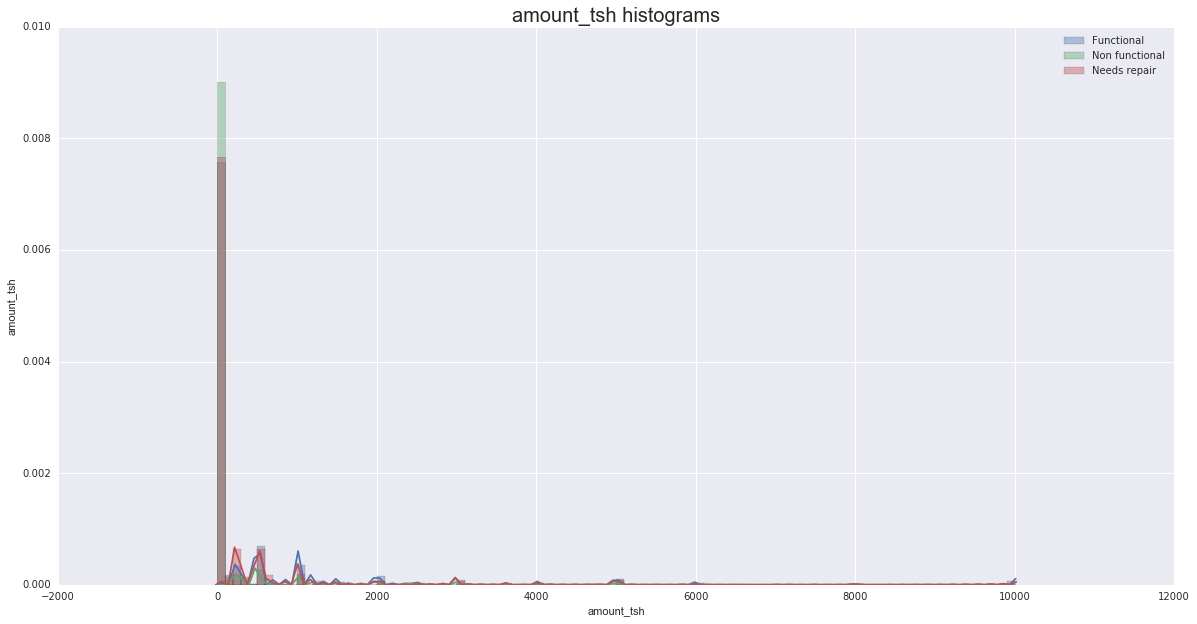

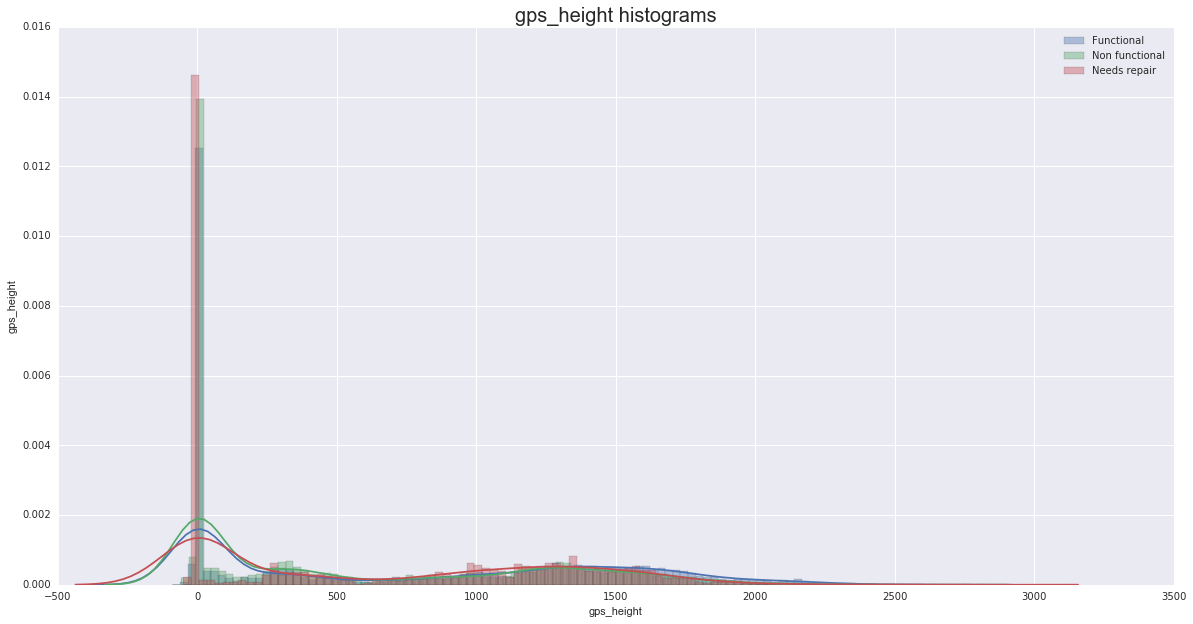

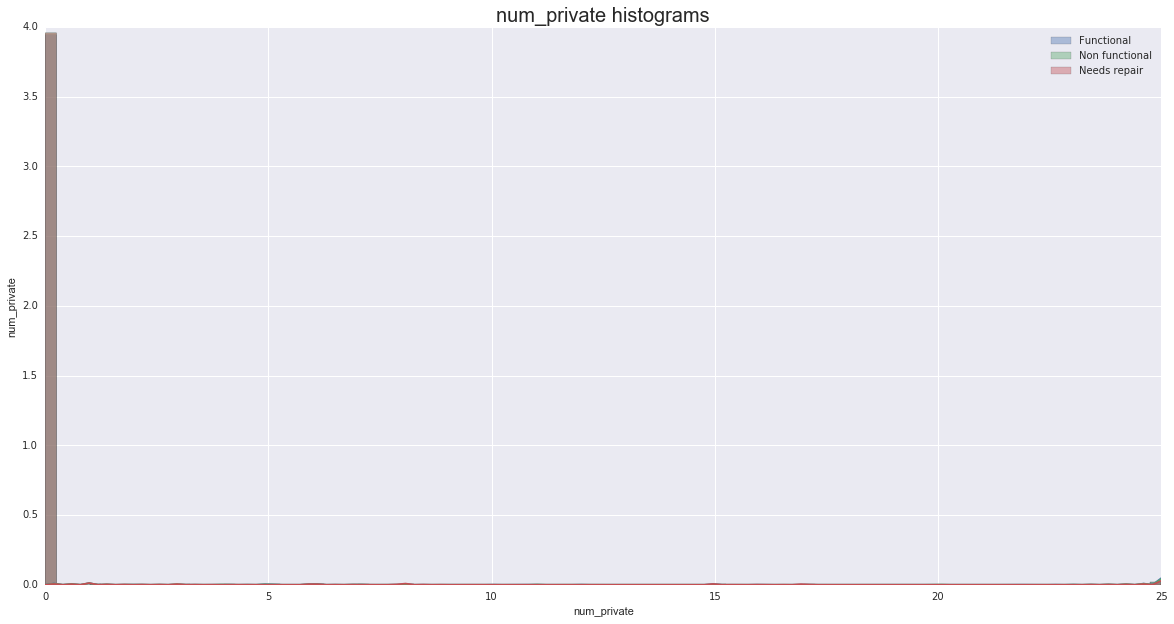

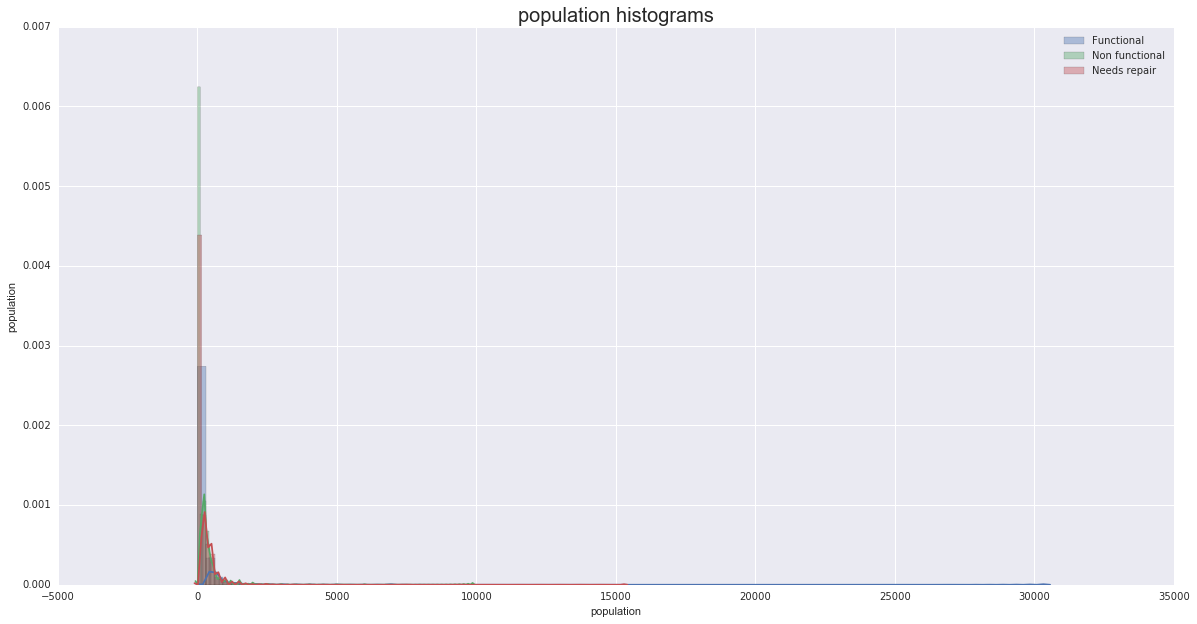

In [8]:
import warnings
warnings.filterwarnings("ignore")
import seaborn as sns

var_names_list = ['amount_tsh','gps_height','num_private','population']
max_val_list = [10000,-1,25,-1,-1,5000,-1]
bins_list = [100,100,100,100,100,100,100]

cols = ['variable','perc_zero_func','perc_zero_nonfunc','perc_zero_repair','unique_vals']
summary_df = pd.DataFrame([],columns=cols)

variable_list = zip(var_names_list,max_val_list,bins_list)

for var,max_val,num_bins in variable_list:
    
    num_vals = len(set(training_values_df[var].values))
    
    func_df = training_values_df[training_values_df['status_group']=='functional']
    nonfunc_df = training_values_df[training_values_df['status_group']=='non functional']
    repair_df = training_values_df[training_values_df['status_group']=='functional needs repair']

    temp_df = pd.DataFrame([[var,
                            1.0*(func_df[var] == 0).sum() / len(func_df),
                            1.0*(nonfunc_df[var] == 0).sum() / len(nonfunc_df),
                            1.0*(repair_df[var] == 0).sum() / len(repair_df),
                            num_vals]],
                           columns=cols)
                            
    summary_df = summary_df.append(temp_df,ignore_index=True)
    if max_val > -1:
        func_df[func_df[var]>max_val] = max_val
        nonfunc_df[nonfunc_df[var]>max_val] = max_val
        repair_df[repair_df[var]>max_val] = max_val

    plt.figure(figsize=(20,10))

    sns.distplot(func_df[var],bins=num_bins)
    sns.distplot(nonfunc_df[var],bins=num_bins)
    sns.distplot(repair_df[var],bins=num_bins)
    plt.title(var + ' histograms',fontsize=20)
    plt.ylabel(var)
    plt.legend(['Functional', 'Non functional','Needs repair'])

summary_df

In [ ]:
#funder
dat['funder']=dat['funder'].astype('category',copy=False)

In [ ]:
dat.funder.value_counts(normalize=True).head(20).plot(kind='bar', figsize=(15,5))
plt.title('Frequency of "Funder" Categories in Dataset: Top 20')
#Top 20-ish funders get close to making up about 50% of the dataset

In [ ]:
dat.funder.sample(5)

In [ ]:
fig, ax = plt.subplots(1,1,figsize=(15,5))
sbrn.distplot(dat.gps_height, kde=True, rug=False)
#sbrn.boxplot(dat.gps_height, ax=ax2)



In [ ]:
sbrn.pairplot(dat, hue="status_group",size=5, diag_kind='kde')